<a href="https://colab.research.google.com/github/DogaSahin/Twitter_Sentiment_Analysis/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Model & Preparing a proper train/test dataset

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dogasahin","key":"d1609876388b666f93f0f0ed278ac683"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kazanova/sentiment140
! unzip sentiment140.zip -d sample_data

Importing necesary libraries

In [ ]:
!pip install nltk
%tensorflow_version 1.x

In [19]:
# for data preprocessing
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np 

# data clearing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string

# Tensorlow Libraries
from tensorflow import keras
from tensorflow.keras.layers import Dense. LSTM, Dropout, Activation, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
import warnings
warnings.filterwarnings("ignore")

In [16]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Getting a labeled data

In [7]:
data = pd.read_csv("sample_data/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python")
data.columns = ["label", "time", "date", "query", "username", "text"]
data.head()


,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


Making a more meaningfull dataset

In [8]:
# Selecting the text and label coloumn Assigning 1 to Positive sentment 4

data=data[['text','label']]
data['label'][data['label']==4]=1

# Separating positive and negative tweets
positive_data = data[data['label'] == 1]
negative_data = data[data['label'] == 0]

# taking half of the dataset for try
positive_data = positive_data.iloc[:int(80000)]
negative_data = negative_data.iloc[:int(80000)]

# Combining positive and negative tweets & making all tweets lowercase so we can work better
data = pd.concat([positive_data, negative_data])
data['text']=data['text'].str.lower()

data['text'].head()
data.tail()

,text,label
79995,@itsaroy they hurt my feelings when they don't...,0
79996,excited that josh will be back in erie in an h...,0
79997,plans of going to the club have been dashed. n...,0
79998,i hate car washing,0
79999,"cannot actually keep my eyes open.., i feel li...",0


Cleaning and removing punctuations


In [9]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].head()

799999            i love health4uandpets u guys r the best 
800000    im meeting up with one of my besties tonight c...
800001    darealsunisakim thanks for the twitter add sun...
800002    being sick can be really cheap when it hurts t...
800003       lovesbrooklyn2 he has that effect on everyone 
Name: text, dtype: object

Removing email, URL's & Numeric numbers


In [10]:
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

data['text']= data['text'].apply(lambda x: cleaning_email(x))


def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))


def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].head()

799999            i love health4uandpets u guys r the best 
800000    im meeting up with one of my besties tonight c...
800001    darealsunisakim thanks for the twitter add sun...
800002    being sick can be really cheap when it hurts t...
800003       lovesbrooklyn2 he has that effect on everyone 
Name: text, dtype: object

Cleaning stopwords from the dataset

In [12]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


799999                    love healthuandpets u guys r best
800000    im meeting one besties tonight cant wait girl ...
800001    darealsunisakim thanks twitter add sunisa got ...
800002    sick really cheap hurts much eat real food plu...
800003                        lovesbrooklyn effect everyone
Name: text, dtype: object

tokenization of tweet

In [13]:
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meeting, one, besties, tonight, cant, wai...
800001    [darealsunisakim, thanks, twitter, add, sunisa...
800002    [sick, really, cheap, hurts, much, eat, real, ...
800003                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

Stemming

In [14]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

data['text']= data['text'].apply(lambda x: stemming_on_text(x))
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meeting, one, besties, tonight, cant, wai...
800001    [darealsunisakim, thanks, twitter, add, sunisa...
800002    [sick, really, cheap, hurts, much, eat, real, ...
800003                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

Applying Lemmatizer

In [17]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))
data['text'].head()


799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meeting, one, besties, tonight, cant, wai...
800001    [darealsunisakim, thanks, twitter, add, sunisa...
800002    [sick, really, cheap, hurts, much, eat, real, ...
800003                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

Data splitting and model building

In [20]:
X=data.text
y=data.label

max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

print(sequences_matrix.shape)

X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

(160000, 500)


# TENSORFLOW

In [21]:
def tensorflow_based_model():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(2000,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer) 
    return model


In [23]:
model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
model.summary()
history=model.fit(X_train,Y_train,batch_size=80,epochs=6, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')
accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 500)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 50)           100000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

Saving model for further calculations

In [29]:
!mkdir -p saved_model
model.save('saved_model/my_model') 
model.save('saved_model/my_model.h5')  # creates a HDF5 file 'my_model.h5'

my_model  my_model.h5
/content


Confusion Matrix



confusion matrix


[[18699  5339]
 [ 6107 17855]]




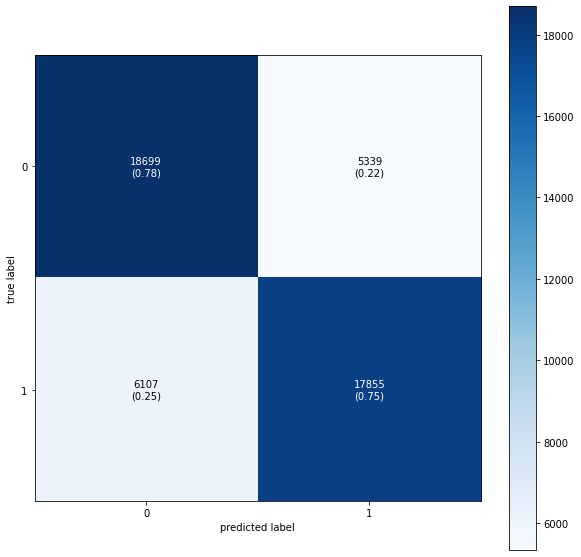

In [ ]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5) 
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

# Twitter Data Classification

Loading the preprocessed data we got from get_tweets

In [31]:
test_data = data = pd.read_csv("/test.csv", encoding = "ISO-8859-1", engine="python")
print(data.head())

   Unnamed: 0                                               text
0           0  ['saps', 'cops', 'told', 'theyÃ¢', 'll', 'face...
1           1  ['come', 'part', 'august', 'audience', 'join',...
2           2  ['lgbtqi', 'activist', 'verge', 'glory', 'read...
3           3  ['vaccine', 'progress', 'looking', 'progress',...
4           4  ['himachalpradesh', 'new', 'covid', 'cases', '...


Making the predictions

In [32]:
X=test_data.text

max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

print(sequences_matrix.shape)


y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5)



(1000, 500)
